<div class="alert alert-danger" style="color:black"><b>Running ML-LV Jupyter Notebooks:</b><br>
    <ol>
        <li>Make sure you are running all notebooks using the <code>adv_ai</code> kernel.
        <li><b>It is very important that you do not create any additional files within the weekly folders on CSCT cloud.</b> Any additional files, or editing the notebooks with a different environment may prevent submission/marking of your work.</li>
            <ul>
                <li>NBGrader will automatically fetch and create the correct folders files for you.</li>
                <li>All files that are not the Jupyter notebooks should be stored in the 'ML-LV/data' directory.</li>
            </ul>
        <li>Please <b>do not pip install</b> any python packages (or anything else). You should not need to install anything to complete these notebooks other than the packages provided in the Jupyter CSCT Cloud environment.</li>
    </ol>
    <b>If you would like to run this notebook locally you should:</b><br>
    <ol>
        <li>Create an environment using the requirements.txt file provided. <b>Any additional packages you install will not be accessible when uploaded to the server and may prevent marking.</b></li>
        <li>Download a copy  of the notebook to your own machine. You can then edit the cells as you wish and then go back and copy the code into/edit the ones on the CSCT cloud in-place.</li>
        <li><b>It is very important that you do not re-upload any notebooks that you have edited locally.</b> This is because NBGrader uses cell metadata to track marked tasks. <b>If you change this format it may prevent marking.</b></li>
    </ol>
</div>

# 2 Translation with Transformers (T5)

## 2.0 Import libraries

1. [Transformers](https://huggingface.co/docs/transformers/index) - is a Python library created by Hugging Face 🤗. It provides APIs and tools to easily download and train state-of-the-art pretrained models.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress Tensorflow messages
os.environ["TF_USE_LEGACY_KERAS"] = "1"  # Use legacy keras for compatibility
import re
import pickle
import nltk
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate import meteor
from transformers import AutoTokenizer, DataCollatorForSeq2Seq, TFT5ForConditionalGeneration, AdamWeightDecay, pipeline
from datasets import Dataset
%matplotlib inline

# Get the status of NBgrader (for skipping cell execution while validating/grading)
grading = True if os.getenv('NBGRADER_EXECUTION') else False

# Set seaborn style for matplotlib plots
plt.style.use('seaborn-v0_8-white')

# Get the project directory (should be in ML-LV)
path = ''
while os.path.basename(os.path.abspath(path)) != 'ML-LV':
    path = os.path.abspath(os.path.join(path, '..'))

# Set the directory to the data folder (should be in ML-LV/data)
data_dir = os.path.join(path, 'data')

# Set the directory to the shared dataset folder (should be in shared/datasets/translate)
dataset_dir = os.path.join(path, '..', 'shared', 'datasets', 'translate')

# Set the directory to the shared models folder (should be in shared/models/translate)
model_dir = os.path.join(path, '..', 'shared', 'models', 'translate')

# Set the nltk data directory (should be in shared/datasets/nltk_data)
nltk.data.path.append(os.path.join(dataset_dir, '..', 'nltk_data'))

## 2.1 Load and pre-process data

The data directory should contain the English and French text file. We will simply loop over the file and separate the English and French phrases. However, this time we wont preform any further pre-processing yet.

In [2]:
if not grading:
    # Preprocess the English and French sentences
    eng_corpus = []
    fr_corpus = []
    with open(os.path.join(dataset_dir, 'english-french.txt'), 'r', encoding='utf-8') as file:
        text = file.read().splitlines()

        for line in text:
            # Split the line into English and French
            line = line.split('\t')

            # Add to corpus
            eng_corpus.append(line[0])
            fr_corpus.append(line[1])

    print(f"Number of English sentences: {len(eng_corpus)}")
    print(f"Number of French sentences: {len(fr_corpus)}")
    print("First 5 sentences: ")
    for i in range(5):
        print(eng_corpus[i] + ' -> ' + fr_corpus[i])

Number of English sentences: 197463
Number of French sentences: 197463
First 5 sentences: 
Go. -> Va !
Go. -> Marche.
Go. -> En route !
Go. -> Bouge !
Hi. -> Salut !


## 2.2 Tokenise and Batch the data

Next we will create a [Dataset](https://huggingface.co/docs/datasets/v2.8.0/en/package_reference/main_classes#main-classes) using the Hugging Face 🤗 Dataset class. This allows us to create a dataset from the English and French corpora, split the data into training and test sets (like the SKlearn function) and also batch the data.

We will also create a [Tokeniser](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/tokenizer) for the T5 model. The tokeniser...tokenises the input and output sequences. It also pads/truncates the sequences to the `max_seq_len` and creates a vocabulary.

Together the `Dataset` and `Tokeniser` automate many of the steps of the data generator and vocabulary creation that we implemented for the Seq2Seq model.

<div class="alert alert-success" style="color:black"><b>Note:</b> Models such as T5 and GPT-3 use prompts to inform the model which task it is to perform. In this case we add the prefix "translate English to French: " to the input sequences.</div>

In [3]:
if not grading:
    # Set the maximum sequence length and batch size
    max_seq_len = 20
    batch_size = 64
    
    # Create a dataset from the English and French sentences
    dataset = Dataset.from_dict({'eng': eng_corpus, 'fr': fr_corpus})
    dataset = dataset.train_test_split(test_size=0.2, shuffle=True, seed=42)
    
    # The prefix is added to the English sentences to indicate that they are to be translated to French
    prefix = "translate English to French: "
    def preprocess_function(examples):
        inputs = [prefix + example for example in examples['eng']]
        targets = [example for example in examples['fr']]
        model_inputs = tokeniser(inputs, text_target=targets, max_length=max_seq_len, truncation=True)
        return model_inputs
    
    # Create a tokeniser for the English and French sentences using the T5 model
    tokeniser = AutoTokenizer.from_pretrained(os.path.join(model_dir, 't5_tokeniser'), model_max_length=max_seq_len)
    # Apply the preprocessing function to the dataset
    tokenised_data = dataset.map(preprocess_function, batched=True, batch_size=batch_size)
    
    # Print the keys and shapes of the training and test datasets
    print(f"Train Dataset: {tokenised_data['train']}")
    print(f"Test Dataset: {tokenised_data['test']}")
    
    # Print the first examples
    for i in range(3):
        print(f"Input Sentence: {tokenised_data['train'][i]['eng']}")
        print(f"Input Vector: {tokenised_data['train'][i]['input_ids']}")
        print(f"Attention Mask: {tokenised_data['train'][i]['attention_mask']}")
        print(f"Target Sentence: {tokenised_data['train'][i]['fr']}")
        print(f"Target Vector: {tokenised_data['train'][i]['labels']}")
        print()

Map:   0%|          | 0/157970 [00:00<?, ? examples/s]

Map:   0%|          | 0/39493 [00:00<?, ? examples/s]

Train Dataset: Dataset({
    features: ['eng', 'fr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 157970
})
Test Dataset: Dataset({
    features: ['eng', 'fr', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 39493
})
Input Sentence: I'm fighting mad because someone stole my bike.
Input Vector: [13959, 1566, 12, 2379, 10, 27, 31, 51, 6237, 11454, 250, 841, 26357, 82, 3724, 5, 1]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Target Sentence: Je suis en rogne parce que quelqu'un a fauché mon vélo.
Target Vector: [1022, 3448, 3, 35, 3, 3822, 29, 15, 9359, 238, 22002, 31, 202, 3, 9, 3, 89, 11532, 154, 1]

Input Sentence: I have great friends.
Input Vector: [13959, 1566, 12, 2379, 10, 27, 43, 248, 803, 5, 1]
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Target Sentence: J'ai de très bons amis.
Target Vector: [446, 31, 9, 23, 20, 1264, 2682, 7, 15245, 5, 1]

Input Sentence: We aren't sure.
Input Vector: [13959, 1566, 12, 2379, 10, 101, 33, 29, 31, 

Next we create a [DataCollator](https://huggingface.co/docs/transformers/main_classes/data_collator#transformers.DataCollatorForSeq2Seq) which is a utility for creating the appropriate encoder and decoder inputs for Seq2Seq models, just as we did with the `MTDataGenerator` class. Then we can create a Tensorflow dataset from the training and test split we created previously.

In [5]:
# Create a data collator for the tokenised data
data_collator = DataCollatorForSeq2Seq(tokenizer=tokeniser, return_tensors="tf")

# Create TensorFlow datasets from the tokenised data
train_set = tokenised_data['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

test_set = tokenised_data['test'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

## 2.3 Build the T5 Model

With the Hugging Face 🤗 library it is very straightforward to load a pre-trained model, and [there are lots to choose from](https://huggingface.co/models). We just need to provide a compatible model name, in this case 't5-small', which will be downloaded and can then be compiled like a standard Keras model.

In [6]:
# Create the AdamWeightDecay optimizer
optimiser = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)
# Load the T5 model
model = TFT5ForConditionalGeneration.from_pretrained(os.path.join(model_dir, 't5_small'))
model.compile(optimizer=optimiser)
model.summary()

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /home/jovyan/ML-LV/../shared/models/translate/t5_small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60506624 (230.81 MB)
Trainable params: 60506624 (230.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Train and evaluate the model

Here we train the model using `model.fit()` as before. However, instead of saving the model weights during training, using the `ModelCheckpoint`, we will simply save the fine-tuned model once training is complete. Usually  only a few epochs are necessary when fine-tuning a model.

<div class="alert alert-danger" style="color:black"><b>Warning:</b> Please do not run this cell on UWE machines/CSCT cloud!<br>
This training process can take a <em>very</em> long time! It could take many hours, depending on your hardware, and especially if you do not have a GPU. Instead, <b>skip this cell and load one the pre-trained model provided</b> (below).
</div>

In [ ]:
# if not grading:
#     model_earlystp = tf.keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0.01,
#         patience=2,
#         verbose=0,
#         mode='min',
#         restore_best_weights=True)
    
#     # Fit the model
#     results = model.fit(train_set, epochs=5, validation_data=test_set, callbacks=[model_earlystp])

#     # Save the model
#     model.save_pretrained(os.path.join(data_dir, 't5_translator'))

#     # Save the results
#     with open(os.path.join(data_dir, 't5_translator_results.pkl'), 'wb') as file:
#         pickle.dump(results.history, file)

Train loss: 0.626
Best validation loss: 0.529


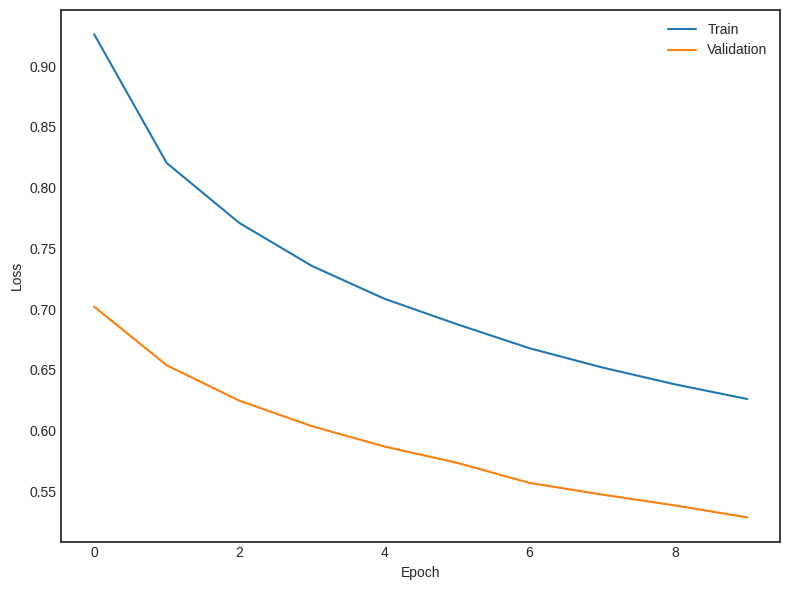

In [7]:
try: results
except NameError: results = None
if grading or not results:
    # Load the results
    with open(os.path.join(model_dir, 't5_translator_results.pkl'), 'rb') as file:
        metrics = pickle.load(file)
elif not grading and results:
    # Or get them from model training
    metrics = results.history

# Show best loss and accuracy
print(f"Train loss: {min(metrics['loss']):.3f}")
print(f"Best validation loss: {min(metrics['val_loss']):.3f}")

# Plot the training loss and accuracy
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(metrics['loss'], label='Train Loss')
ax.plot(metrics['val_loss'], label='Validation Loss')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

## 2.4 Calculate BLEU and METEOR scores

Once the model is trained we can evaluate it by calculating the BLEU and METEOR scores. First we should load the weights of the model as well as the tokeniser. The process is similar to before:

1. Loop over each batch in the test set

2. Use the model to generate predictions

3. Convert the predicted token ids back into words, and similarly for the actual translation. In this case the `.decode()` function returns a complete string, so we need to split them back into tokens and ignore everything after the `</s>` token.

4. Calculate BLEU and METEOR for all the candidate and reference pairs

<div class="alert alert-danger" style="color:black"><b>Warning:</b> This cell is quite computationally expensive. It is strongly recommended you only run ~10-100 batches, just to get a picture of the BLEU and METEOR score.
</div>

In [8]:
# Load the best model found during training
model = TFT5ForConditionalGeneration.from_pretrained(os.path.join(model_dir,'t5_translator'))
tokeniser = AutoTokenizer.from_pretrained(os.path.join(model_dir, 't5_tokeniser'))

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at /home/jovyan/ML-LV/../shared/models/translate/t5_translator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [9]:
if not grading: 
    candidates = []
    references = []

    # Just make predictions on the first n batches
    num_batches = 10
    for i in range(num_batches):
        example = next(iter(test_set))

        # Predict on the test set
        inp_ids, attn_mask, labels = example[0]['input_ids'], example[0]['attention_mask'], example[1]
        outputs = model(input_ids=inp_ids, attention_mask=attn_mask, decoder_input_ids=None, labels=labels)

        # Convert the logits to predicted ids
        predictions = tf.nn.softmax(outputs['logits'], axis=-1)
        predicted_ids = tf.argmax(predictions, axis=-1).numpy()

        # Get the predicted sentences and the reference sentence
        for j in range(predicted_ids.shape[0]):

            # Use the tokeniser to decode the predicted ids
            predicted_sentence = tokeniser.decode(predicted_ids[j], skip_special_tokens=False)
            predicted_sentence = re.sub(r"([?.!,¿])", r" \1 ", predicted_sentence)
            # Ignore everything after the </s> token
            predicted_sentence = predicted_sentence.split('</s>')[0]
            predicted_sentence = predicted_sentence.strip().split(' ')
            candidates.append(predicted_sentence)

            # Use the tokeniser to decode the reference ids from the labels
            label_ids = np.delete(labels[j], np.where(labels[j] == -100)) # Remove the padding tokens
            reference_sentence = tokeniser.decode(label_ids, skip_special_tokens=True)
            reference_sentence = re.sub(r"([?.!,¿])", r" \1 ", reference_sentence)
            reference_sentence = reference_sentence.strip().split(' ')
            references.append(reference_sentence)

    # Smoothing function accounts for cases where the candidate sentence is shorter than the reference sentence
    ch = SmoothingFunction().method7  # Chen and Cherry method

    # Cumulative - calculation of individual n-gram scores at all orders from 1 to n
    c_1g = corpus_bleu(references, candidates, weights=(1, 0, 0, 0), smoothing_function=ch)
    c_2g = corpus_bleu(references, candidates, weights=(0.5, 0.5, 0, 0), smoothing_function=ch)
    c_3g = corpus_bleu(references, candidates, weights=(0.33, 0.33, 0.33, 0), smoothing_function=ch)
    c_4g = corpus_bleu(references, candidates, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=ch)
    print(f"BLEU Cumulative 1-gram: {c_1g:.4f}, 2-gram: {c_2g:.4f}, 3-gram: {c_3g:.4f}, 4-gram: {c_4g:.4f}")

    meteor_scores = [round(meteor([references[i]], candidates[i]), 5) for i in range(len(references))]
    print(f"Completions METEOR: Mean={np.mean(meteor_scores):.4f}, Max={np.max(meteor_scores):.4f}, Min={np.min(meteor_scores):.4f}")

BLEU Cumulative 1-gram: 0.4377, 2-gram: 0.2528, 3-gram: 0.1489, 4-gram: 0.0844
Completions METEOR: Mean=0.7409, Max=0.9998, Min=0.0000


## 2.5 Translate text

Once the model is trained we can now use it to translate some text! First we should load the weights of the model as well as the tokeniser. Then we can set choose a phrase for translation and (optionally) set the correct translation. Then we can use a [Pipeline](https://huggingface.co/docs/transformers/v4.26.0/en/main_classes/pipelines#transformers.pipeline) to create a full end-to-end translation function with our model and tokeniser.

In [12]:
# Test the model on a sentence
input_sentence = "I am a student."
correct_translation = "Je suis un étudiant."

# Create a pipeline to translate the input sentence
translator = pipeline("translation_en_to_fr", model=model, tokenizer=tokeniser)
predicted_translation = translator(input_sentence)

print(f"Input sentence: {input_sentence}")
print(f"Translation: {correct_translation}")
print(f"Predicted translation: {predicted_translation[0]['translation_text']}")

Device set to use 0


Input sentence: I am a student.
Translation: Je suis un étudiant.
Predicted translation: Ich bin student.


<div class="alert alert-success" style="color:black"><h3>Before you submit this notebook to NBGrader for marking:</h3> 

1. Make sure have completed all exercises marked by <span style="color:blue">**blue cells**</span>.
2. For automatically marked exercises ensure you have completed any cells with `# YOUR CODE HERE`. Then click 'Validate' button above, or ensure all cells run without producing an error.
3. For manually marked exercises ensure you have completed any cells with `"YOUR ANSWER HERE"`.
4. Ensure all cells are run with their output visible.
5. Fill in your student ID (**only**) below.
6. You should now **save and download** your work.

</div>

**Student ID:** 15006280